In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from preprocess import load_clean_data, data_stats, create_features, create_features_labels
from plots import plot_validation_diagram, plot_samples, plot_avg, plot_ewma, detect_raw_signal, plot_validation_diagrams
from IPython.display import display
from keras.models import load_model
from evaluate import evaluate_ae_models, evaluate_seq_models, evaluate_dummy

Using TensorFlow backend.


### Load whole dataset

In [25]:
data = load_clean_data(range(48))

Error while parsing file inxed=2 , [Errno 2] No such file or directory: 'dataset/2.ann.gz'
Error while parsing file inxed=4 , [Errno 2] No such file or directory: 'dataset/4.ann.gz'
Error while parsing file inxed=44 , [Errno 2] No such file or directory: 'dataset/44.ann.gz'


### Show beat types distribution

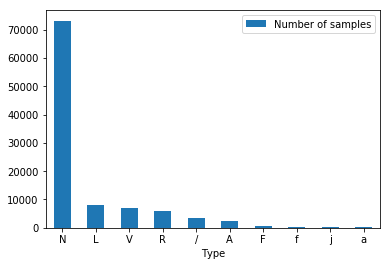

In [26]:
df = data_stats(data)
type_occ = pd.DataFrame(df.sum().sort_values(ascending=False).head(10), columns=['Number of samples'])
type_occ.index.name = 'Type'
type_occ.plot(kind='bar', rot=0);

In [27]:
df[df['/'] != 0]

,?,/,a,A,B,e,E,f,F,j,J,L,n,N,Q,r,R,S,V
5,0,2078,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,59
34,0,1542,0,0,0,0,0,260,0,0,0,0,0,244,0,0,0,0,162


### Show number of 'A' beat per patient

In [29]:
sorted_a = df[['A', 'N', 'V', 'L', 'R', '/']].sort_values(by='A', ascending=False)

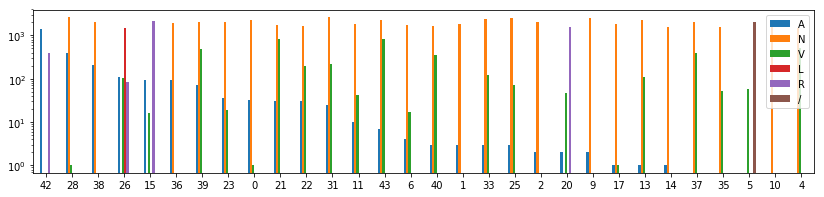

In [30]:
sorted_a[0:30].plot(kind='bar', rot = 0, logy=True, figsize=(14,3));

### Split data into train and test set

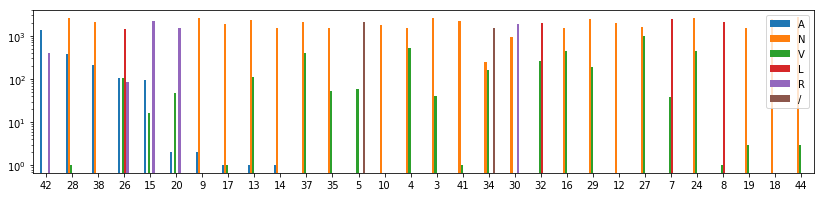

In [31]:
data_index = pd.concat([sorted_a[0:5],sorted_a[20:]])
data_index.head(10)
data_index.plot(kind='bar', rot = 0, logy=True, figsize=(14,3));

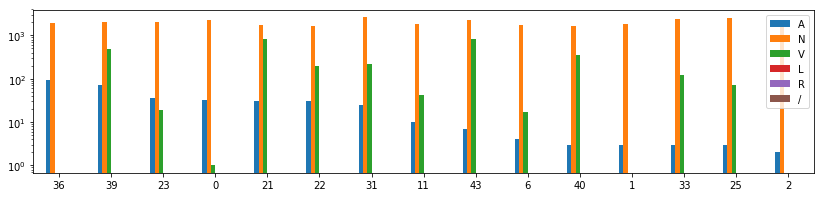

In [32]:
val_index = sorted_a[5:20]
val_index.plot(kind='bar', rot = 0, logy=True, figsize=(14,3));

In [36]:
data_index.index, val_index.index

(Int64Index([42, 28, 38, 15,  9, 17, 13, 14, 37, 35,  5, 10,  4,  3, 41, 32, 16,
             29, 12, 27, 24, 19, 18, 44],
            dtype='int64'),
 Int64Index([36, 39, 23, 0, 21, 22, 31, 11, 43, 6, 40, 1, 33, 25, 2, 7, 8, 20,
             26, 30, 34],
            dtype='int64'))

L 26, 32 ->t, 7, 8, -> v

R 15, 42 ->t,  20, 26,30 - >v

/ -> 5 ->t, 34 - >v

In [34]:
val_index = val_index.append(data_index.loc[7])
val_index = val_index.append(data_index.loc[8])
val_index = val_index.append(data_index.loc[20])
val_index = val_index.append(data_index.loc[26])
val_index = val_index.append(data_index.loc[30])
val_index = val_index.append(data_index.loc[34])

In [35]:
data_index.drop([7, 8, 20, 26, 30, 34], inplace=True)

### Check if the dataset do not intersect

In [37]:
set_d, set_v = set(data_index.index.values), set(val_index.index.values)

In [38]:
set_d.intersection(set_v)

set()

In [39]:
train = data[data_index.index.values]
validation = data[val_index.index.values]

### Investigate sample signals

In [17]:
#plot_samples(train[-10:-5])

### Create small train/test set

In [41]:
lb = LabelBinarizer()
non_beats, beat_types = 1, ['A', 'N', 'V', 'L', 'R', '/']
x_train_all, labels = create_features_labels(data, 784, non_beats_per_beat = non_beats, beat_types=beat_types)
y_train_all = lb.fit_transform(labels)

x_test_all, labels = create_features_labels(validation, 784, non_beats_per_beat = non_beats, beat_types=beat_types)
y_test_all = lb.transform(labels)

In [42]:
x_train_all.shape, x_test_all.shape

((200692, 784), (93730, 784))

In [43]:
df = pd.DataFrame(np.c_[np.sum(y_train_all, axis = 0), np.sum(y_test_all, axis = 0)], index = lb.classes_, columns = ['Train', 'Validation'])
df.index.name = 'Beat type'
display(df)

,Train,Validation
Beat type,,
/,3615,1540
A,2537,463
L,8065,6066
N,73067,31825
NB,100346,46865
R,5998,3438
V,7064,3533


In [44]:
x_train, _, y_train, _ = train_test_split(x_train_all, y_train_all, test_size = .9)
x_test, _, y_test, _ = train_test_split(x_test_all, y_test_all, test_size = .9)

In [45]:
x_train.shape, x_test.shape

((20069, 784), (9373, 784))

In [46]:
pd.DataFrame(np.c_[np.sum(y_train, axis = 0), np.sum(y_test, axis = 0)], index = lb.classes_, columns = ['Train', 'Test'])

,Train,Test
/,352,162
A,289,53
L,818,570
N,7283,3179
NB,10014,4703
R,613,357
V,700,349


In [47]:
ann = validation[0]['annotations']
sig = validation[0]['signals']

In [37]:
ann[ann['Type'] == 'A'][:10]

,Time,Sample,Type
60,0:49.822,17936,A
376,5:18.703,114733,A
381,5:22.600,116136,A
395,5:34.283,120342,A
472,6:41.181,144425,A
483,6:48.508,147063,A
485,6:49.103,147277,A
486,6:49.544,147436,A
491,6:51.872,148274,A
492,6:52.289,148424,A


### Check NN autoencoder

Running autoencoder with config: [784, [], 128]


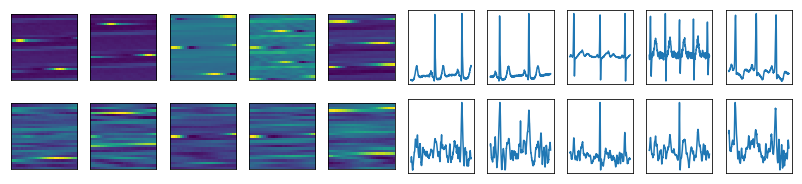

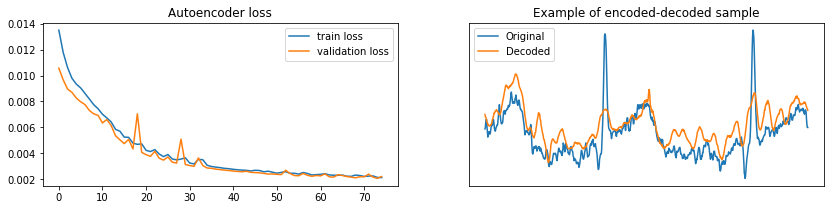

Evaluating model with fc: [3]


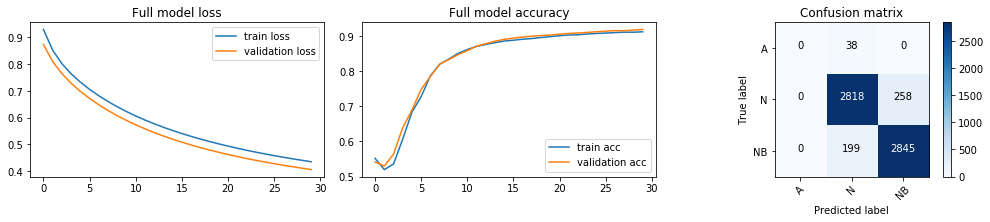

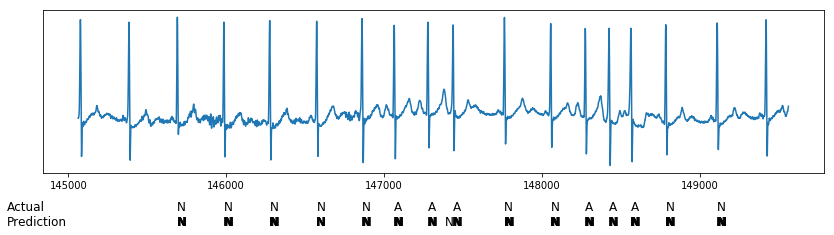

/home/buzz/anaconda2/envs/py3gpu/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Evaluating model with fc: [64, 3]


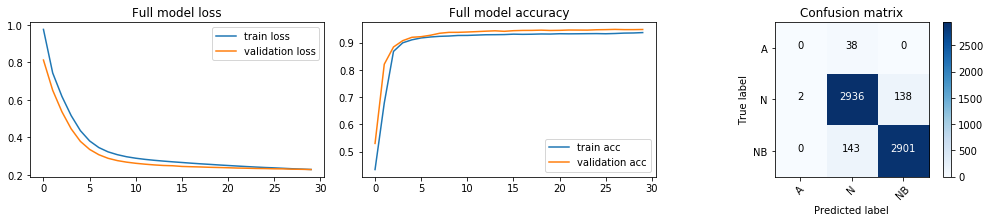

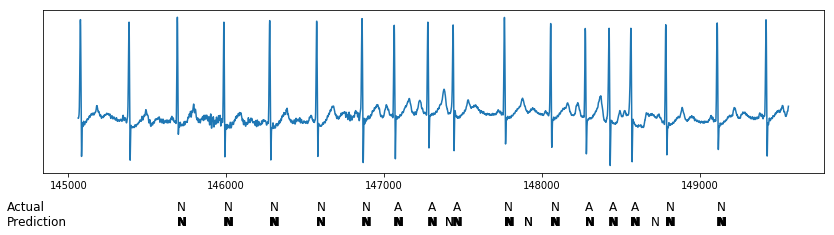

Evaluating model with fc: [128, 3]


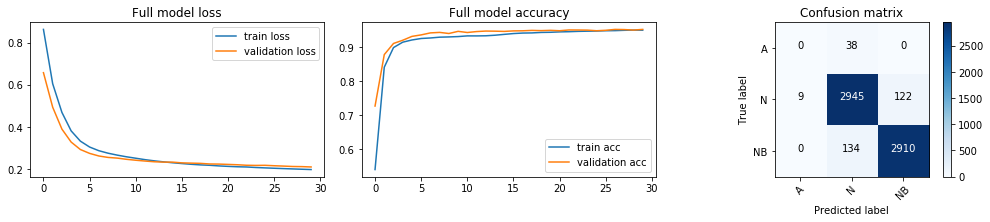

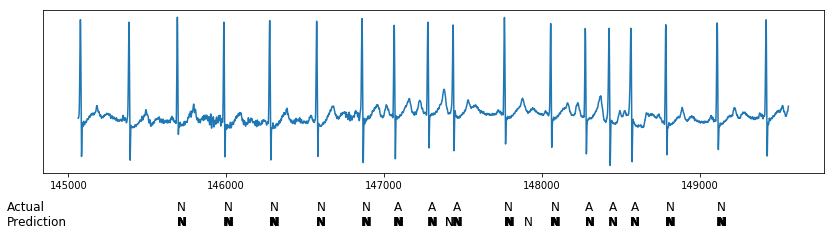

Running autoencoder with config: [784, [256, 128], 64]


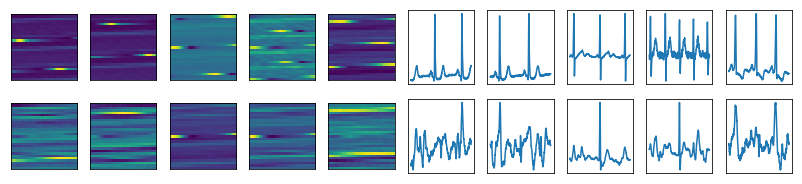

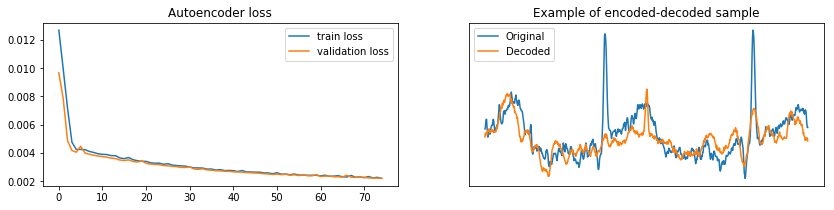

Evaluating model with fc: [3]


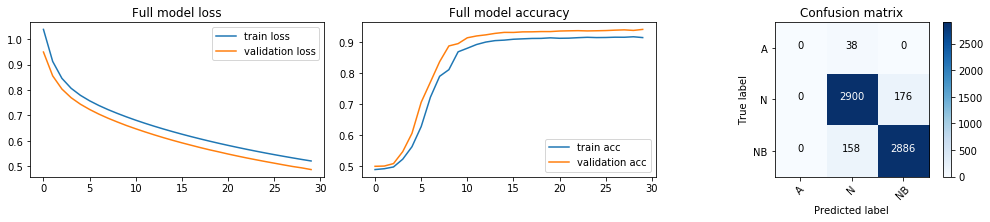

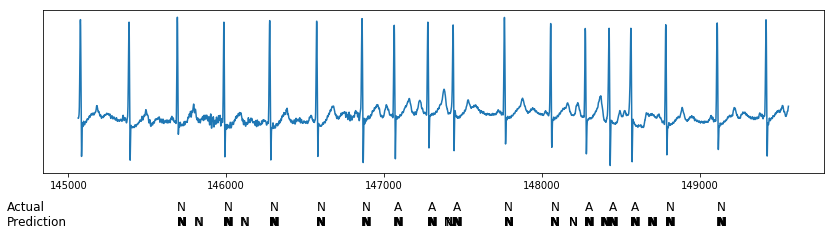

Evaluating model with fc: [64, 3]


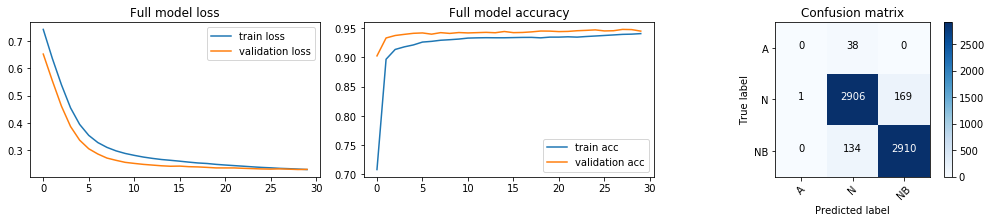

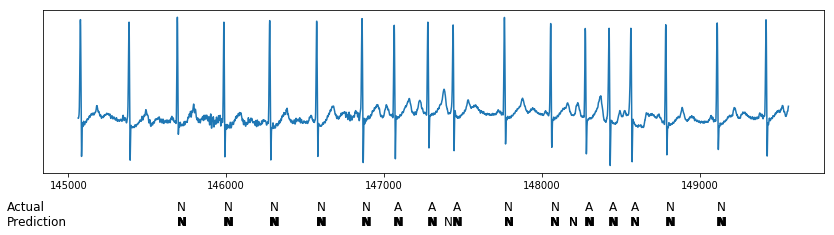

Evaluating model with fc: [128, 3]


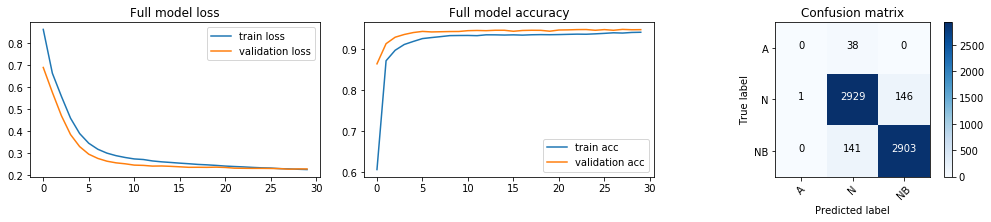

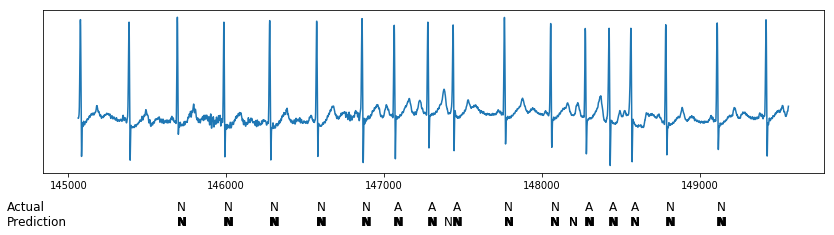

In [218]:
config = {
    'use_conv': False,
    'ae' : [ [784,[], 128] ],
    'fc' : [ [3] ]
#     'ae' : [ [784,[], 128], [784, [256, 128], 64]],
#     'fc' : [ [3], [64,3], [128, 3]]

}
nn_models = evaluate_ae_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                               ae_epochs=75, full_model_epochs=30, load_prev_ae=False, load_prev_full=False)

### Check CONV autoencoder

Running autoencoder with config: [(28, 28), [16, 8, 8], (4, 4)]


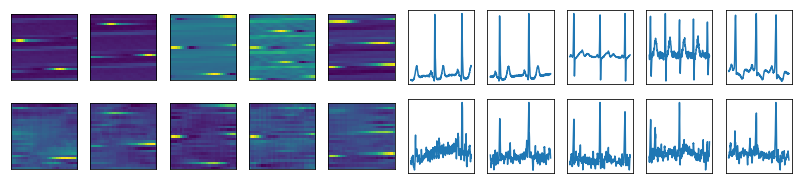

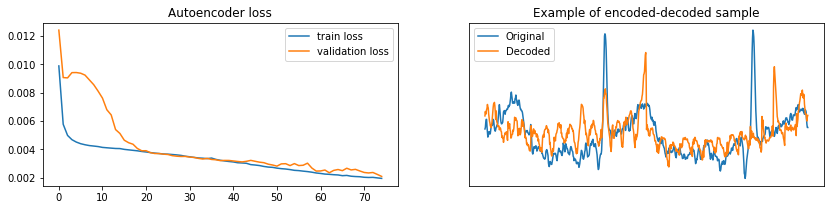

Evaluating model with fc: [3]


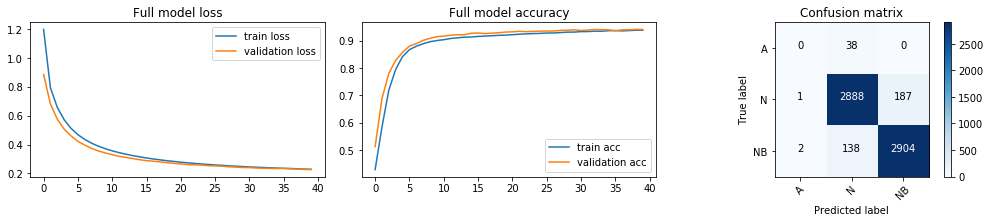

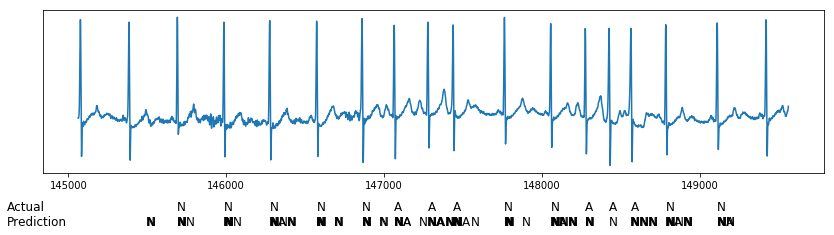

Evaluating model with fc: [64, 3]


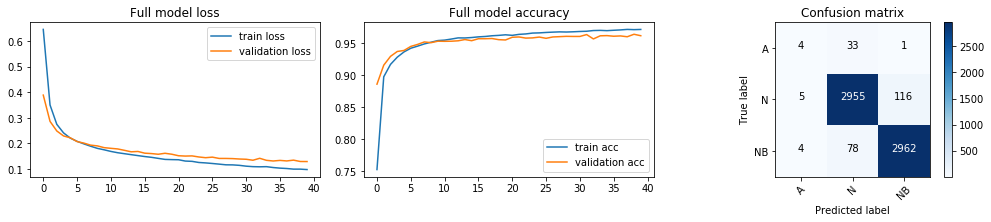

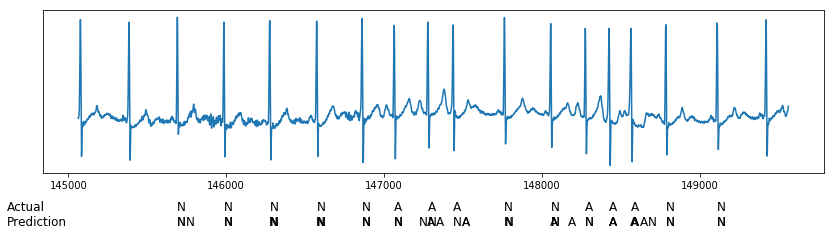

Evaluating model with fc: [128, 3]


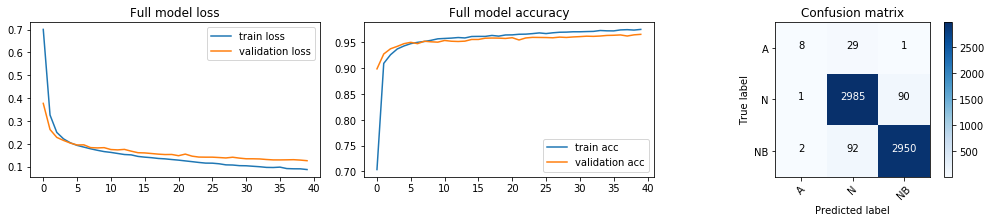

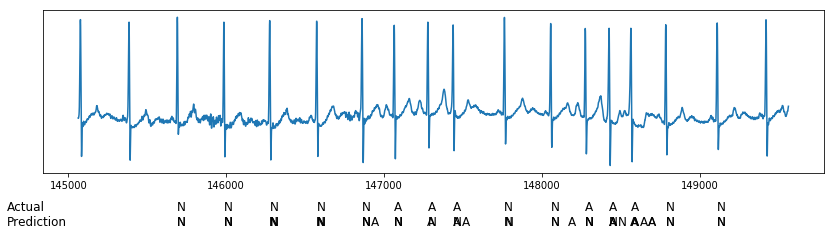

Evaluating model with fc: [1024, 3]


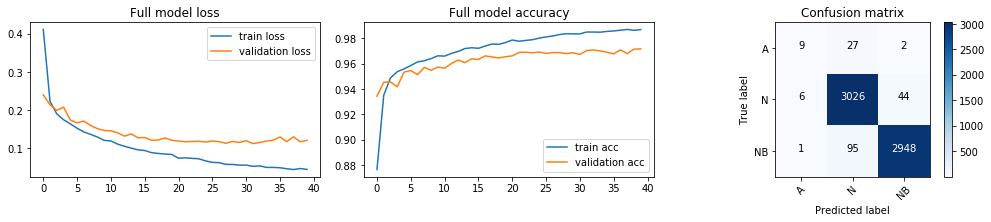

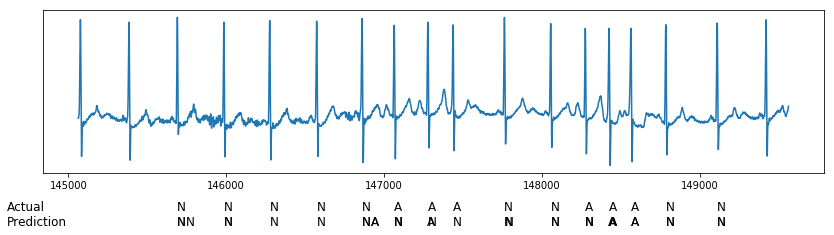

Running autoencoder with config: [(28, 28), [32, 16, 16], (4, 4)]


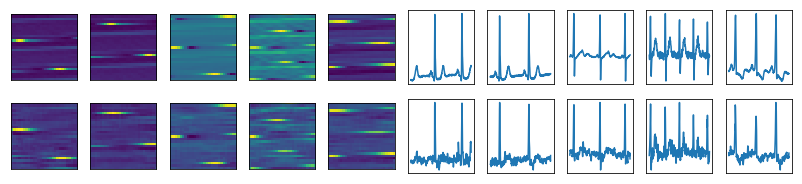

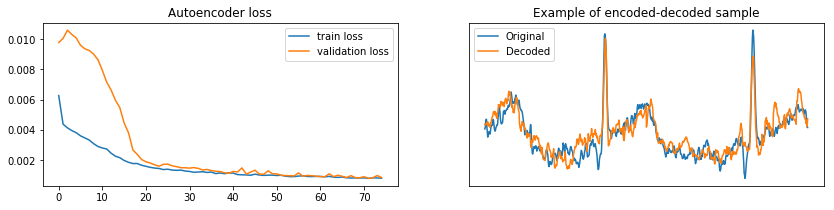

Evaluating model with fc: [3]


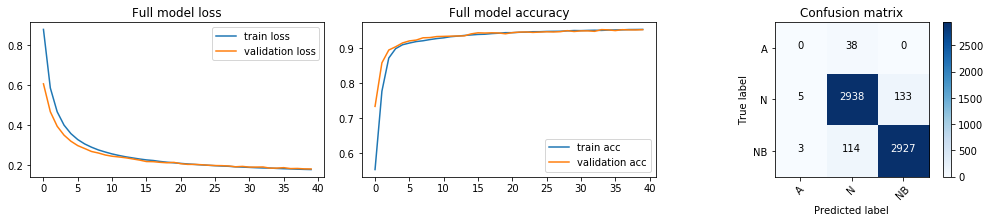

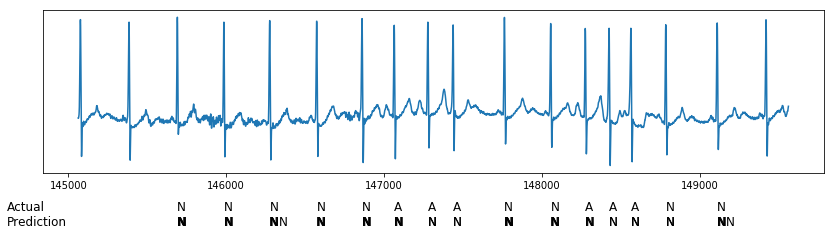

Evaluating model with fc: [64, 3]


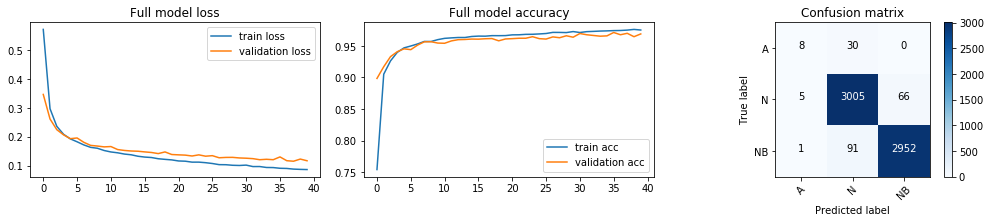

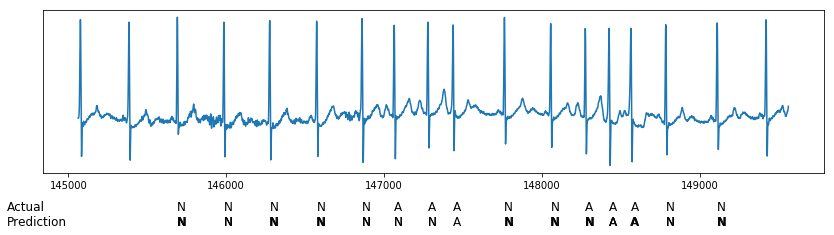

Evaluating model with fc: [128, 3]


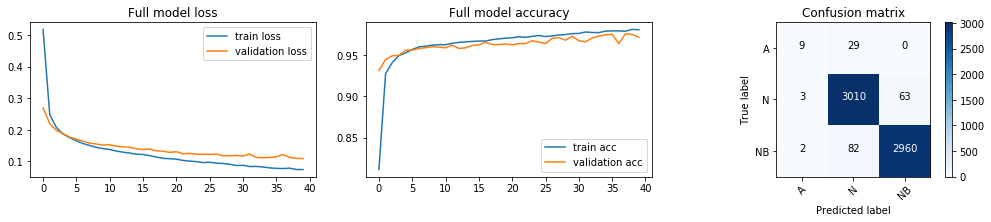

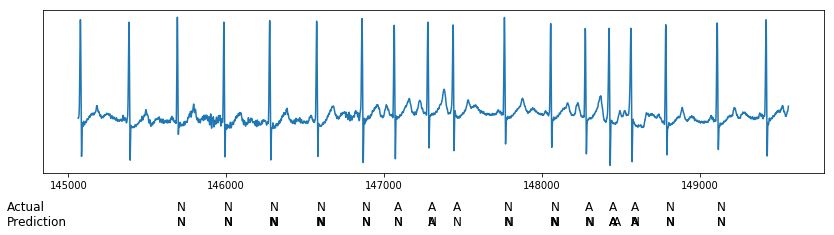

Evaluating model with fc: [1024, 3]


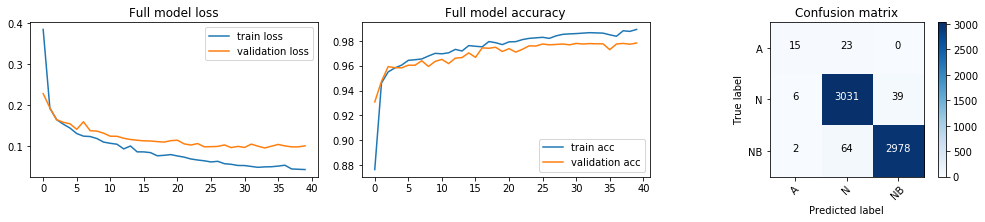

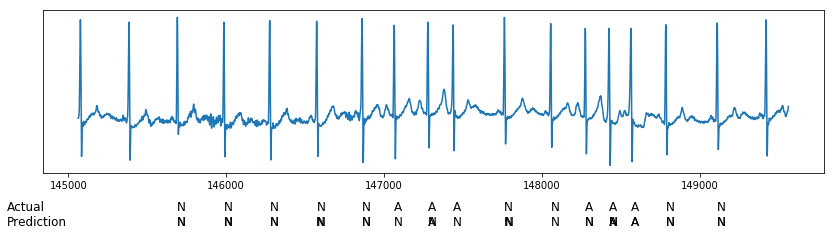

In [219]:
config = {
    'use_conv' : True,
    'ae' : [[(28, 28), [16, 8 , 8], (4,4)],
    'fc' : [ [128,3] ]
}
conv_models = evaluate_ae_models(config,  x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                    ae_epochs=75, full_model_epochs=40, load_prev_ae=False, load_prev_full=False)

### Sequential models

Running sequential model: {'filters': [16, 32, 64], 'units': [1024, 7], 'dropout': 0.5}
Successfully loaded weights
Train on 20069 samples, validate on 9373 samples
Epoch 1/5
20069/20069 [==============================] - 4s - loss: 0.0284 - acc: 0.9922 - val_loss: 0.2176 - val_acc: 0.9573
Epoch 2/5
20069/20069 [==============================] - 4s - loss: 0.0255 - acc: 0.9935 - val_loss: 0.1764 - val_acc: 0.9765
Epoch 3/5
20069/20069 [==============================] - 4s - loss: 0.0213 - acc: 0.9942 - val_loss: 0.1484 - val_acc: 0.9776
Epoch 4/5
20069/20069 [==============================] - 4s - loss: 0.0220 - acc: 0.9947 - val_loss: 0.1993 - val_acc: 0.9762
Epoch 5/5
20069/20069 [==============================] - 4s - loss: 0.0237 - acc: 0.9936 - val_loss: 0.1671 - val_acc: 0.9778


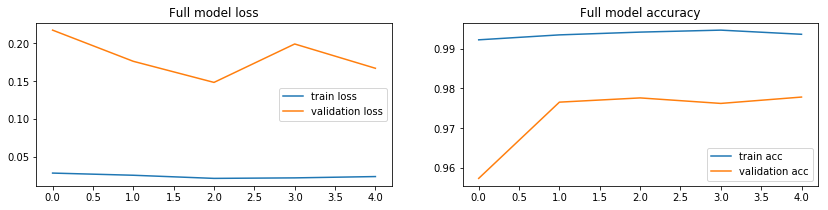

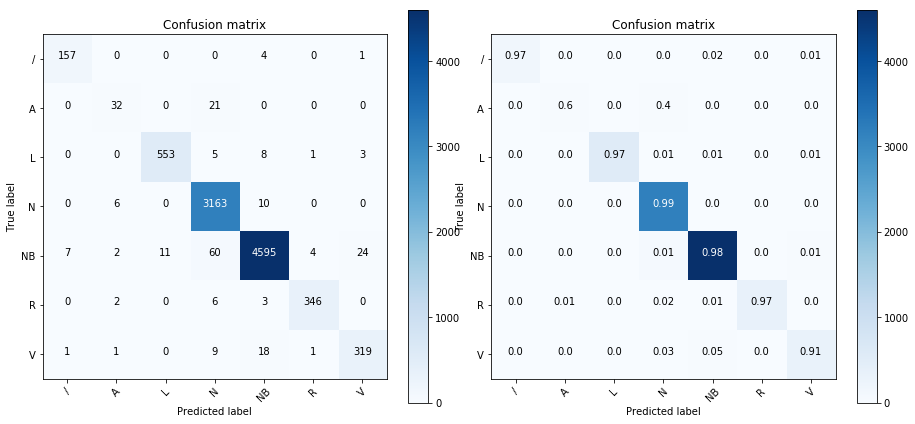

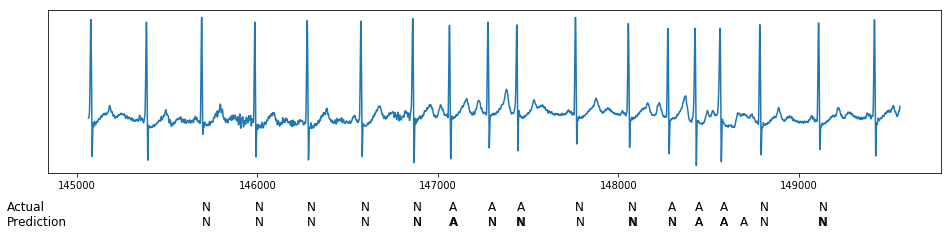

In [59]:
config = [
#     {'filters' : [ 4,  8, 16], 'units': [1024, 3], 'dropout': 0.5},
#     {'filters' : [ 8, 16, 32], 'units': [1024, 3], 'dropout': 0.5},
    {'filters' : [16, 32, 64], 'units': [1024, 7], 'dropout': 0.5},    
#     {'filters' : [16, 32, 64], 'units': [2048, 3], 'dropout': 0.5},
]
seq_models = evaluate_seq_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                 epochs = 5, load_prev=True)

('Running sequential model:', "{'units': [1024, 4], 'dropout': 0.5, 'filters': [16, 32, 64]}")
Successfully loaded weights
Train on 17884 samples, validate on 6853 samples
Epoch 1/5
17884/17884 [==============================] - 33s - loss: 0.0346 - acc: 0.9899 - val_loss: 0.1319 - val_acc: 0.9734
Epoch 2/5
17884/17884 [==============================] - 37s - loss: 0.0269 - acc: 0.9926 - val_loss: 0.1358 - val_acc: 0.9759
Epoch 3/5
17884/17884 [==============================] - 40s - loss: 0.0244 - acc: 0.9926 - val_loss: 0.1594 - val_acc: 0.9679
Epoch 4/5
17884/17884 [==============================] - 41s - loss: 0.0236 - acc: 0.9926 - val_loss: 0.1298 - val_acc: 0.9762
Epoch 5/5
17884/17884 [==============================] - 39s - loss: 0.0223 - acc: 0.9937 - val_loss: 0.1446 - val_acc: 0.9767


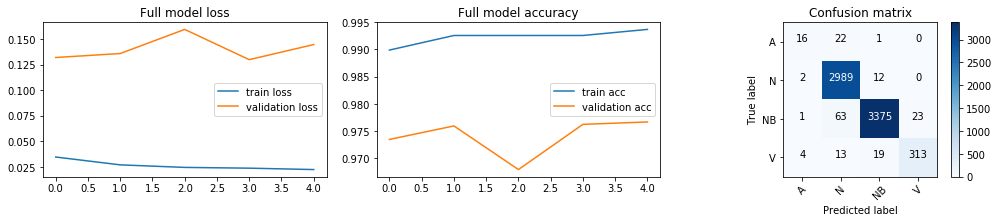

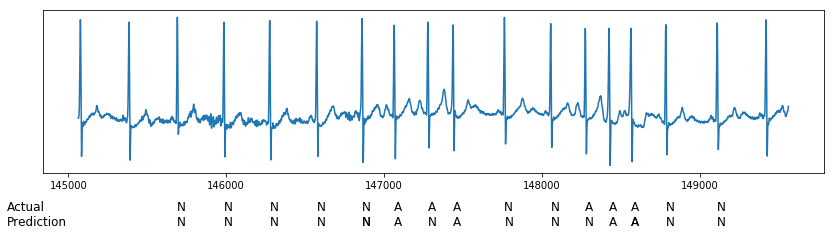

In [43]:
config = [
#     {'filters' : [ 4,  8, 16], 'units': [1024, 3], 'dropout': 0.5},
#     {'filters' : [ 8, 16, 32], 'units': [1024, 3], 'dropout': 0.5},
    {'filters' : [16, 32, 64], 'units': [1024, 4], 'dropout': 0.5},    
#     {'filters' : [16, 32, 64], 'units': [2048, 3], 'dropout': 0.5},
]
seq_models = evaluate_seq_models(config, x_train, x_test, y_train, y_test, lb.classes_, ann, sig, 
                                 epochs = 5, load_prev=True)

### Print comparison reports for all architectures

In [60]:
def print_raport(result):
    df  = pd.DataFrame(result)
    display(df[['ae', 'fc', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [61]:
def print_seq_raport(result):
    df  = pd.DataFrame(result)    
    display(df[['filters', 'units', 'dropout', 'val_acc', 'precision', 'recall', 'f1_score']].round(2))

In [221]:
print_raport(nn_models); 

,val_acc,precision,recall,f1_score
0,0.35,0.33,0.34,0.27


,ae,fc,val_acc,precision,recall,f1_score
0,"[784, [], 128]",[3],0.92,0.61,0.62,0.61
1,"[784, [], 128]","[64, 3]",0.95,0.63,0.64,0.63
2,"[784, [], 128]","[128, 3]",0.95,0.63,0.64,0.64
3,"[784, [256, 128], 64]",[3],0.94,0.63,0.63,0.63
4,"[784, [256, 128], 64]","[64, 3]",0.94,0.63,0.63,0.63
5,"[784, [256, 128], 64]","[128, 3]",0.95,0.63,0.64,0.63


In [222]:
print_raport(conv_models)

,ae,fc,val_acc,precision,recall,f1_score
0,"[(28, 28), [16, 8, 8], (4, 4)]",[3],0.94,0.63,0.63,0.63
1,"[(28, 28), [16, 8, 8], (4, 4)]","[64, 3]",0.96,0.74,0.68,0.70
2,"[(28, 28), [16, 8, 8], (4, 4)]","[128, 3]",0.97,0.89,0.72,0.75
3,"[(28, 28), [16, 8, 8], (4, 4)]","[1024, 3]",0.97,0.84,0.73,0.76
4,"[(28, 28), [32, 16, 16], (4, 4)]",[3],0.95,0.64,0.64,0.64
5,"[(28, 28), [32, 16, 16], (4, 4)]","[64, 3]",0.97,0.84,0.72,0.75
6,"[(28, 28), [32, 16, 16], (4, 4)]","[128, 3]",0.97,0.86,0.73,0.76
7,"[(28, 28), [32, 16, 16], (4, 4)]","[1024, 3]",0.98,0.87,0.79,0.82


In [62]:
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 7]",0.5,0.98,0.93,0.91,0.92


### Train validate on all data

In [32]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024, 4], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 2, load_prev=True)

Running sequential model: {'filters': [16, 32, 64], 'units': [1024, 4], 'dropout': 0.5}
Successfully loaded weights


ValueError: Input arrays should have the same number of samples as target arrays. Found 205854 input samples and 308781 target samples.

Running sequential model: {'filters': [16, 32, 64], 'units': [1024, 6], 'dropout': 0.5}
Successfully loaded weights
Train on 205854 samples, validate on 86010 samples
Epoch 1/2
205854/205854 [==============================] - 43s - loss: 0.0424 - acc: 0.9907 - val_loss: 0.0474 - val_acc: 0.9897
Epoch 2/2
205854/205854 [==============================] - 42s - loss: 0.0389 - acc: 0.9916 - val_loss: 0.0383 - val_acc: 0.9923


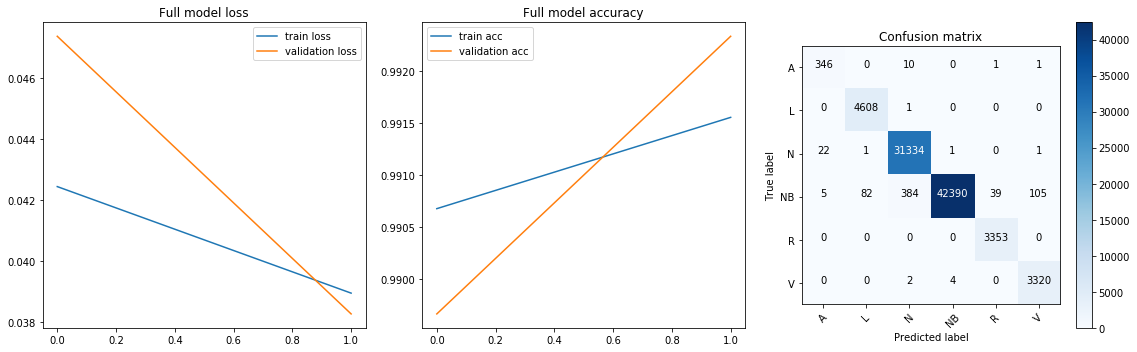

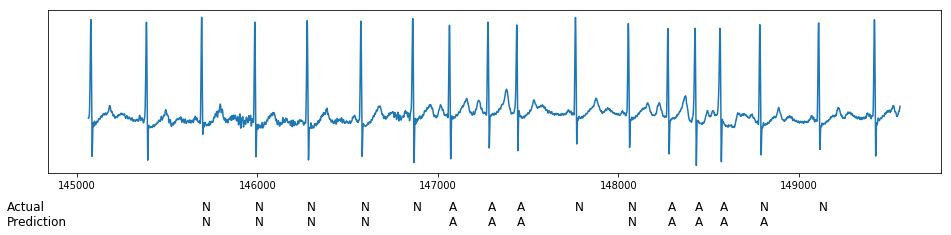

In [32]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024, 6], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 2, load_prev=True)

Running sequential model: {'filters': [16, 32, 64], 'units': [1024, 7], 'dropout': 0.5}
Successfully loaded weights
Train on 200692 samples, validate on 93730 samples
Epoch 1/4
200692/200692 [==============================] - 46s - loss: 0.0304 - acc: 0.9926 - val_loss: 0.0557 - val_acc: 0.9905
Epoch 2/4
200692/200692 [==============================] - 45s - loss: 0.0285 - acc: 0.9932 - val_loss: 0.0419 - val_acc: 0.9920
Epoch 3/4
200692/200692 [==============================] - 43s - loss: 0.0277 - acc: 0.9932 - val_loss: 0.0503 - val_acc: 0.9909
Epoch 4/4
200692/200692 [==============================] - 42s - loss: 0.0278 - acc: 0.9932 - val_loss: 0.0482 - val_acc: 0.9918


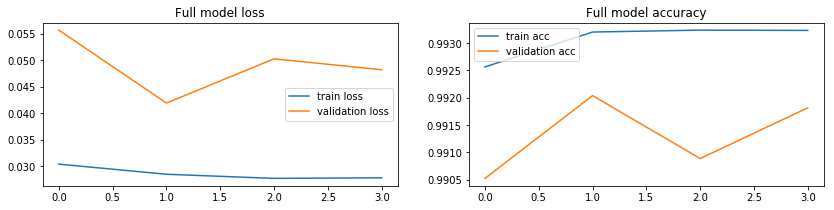

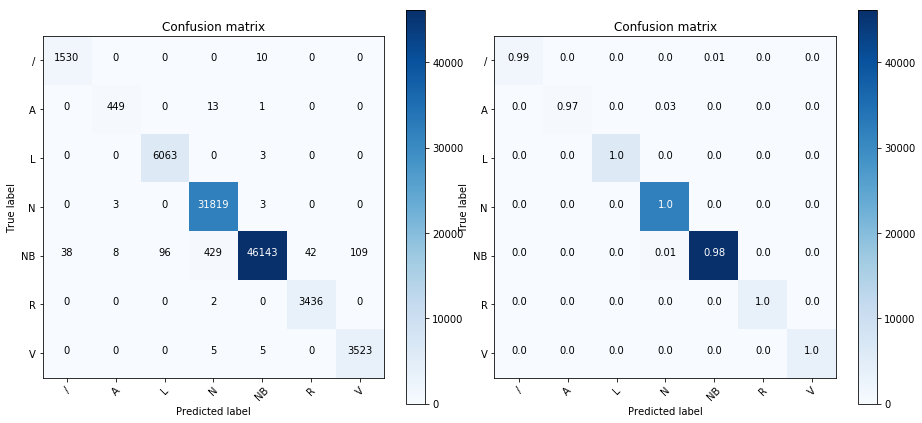

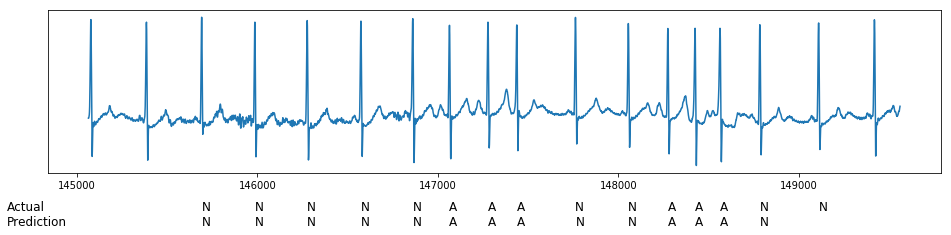

In [83]:
config = [
    {'filters' : [16, 32, 64], 'units': [1024, 7], 'dropout': 0.5},    
]
seq_models = evaluate_seq_models(config, x_train_all, x_test_all, y_train_all, y_test_all, lb.classes_, ann, sig, 
                                 epochs = 4, load_prev=True)

In [31]:
# NAV
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 4]",0.5,0.99,0.97,0.97,0.97


In [33]:
# NAVLR
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 6]",0.5,0.99,0.98,0.99,0.98


In [84]:
# NAVLR/
print_seq_raport(seq_models)

,filters,units,dropout,val_acc,precision,recall,f1_score
0,"[16, 32, 64]","[1024, 7]",0.5,0.99,0.98,0.99,0.99


### Save top model

In [85]:
top_model_path = 'weights/top_model_navlr_.h5'

In [86]:
tm = seq_models[0]['model']

In [87]:
tm.save(top_model_path)

In [48]:
lb.classes_

array(['A', 'L', 'N', 'NB', 'R', 'V'],
      dtype='<U2')

### Load top model

In [50]:
tm = seq_models[0]['model']

In [43]:
top_model_path = 'weights/top_model_navlr.h5'

In [44]:
tm = load_model(top_model_path)

### Check localization and classification for various patients for the final model

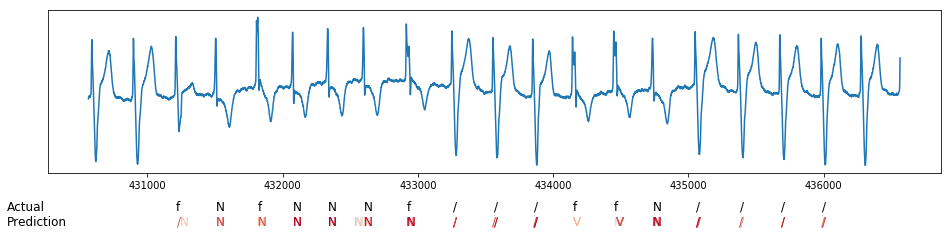

In [88]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['/'])

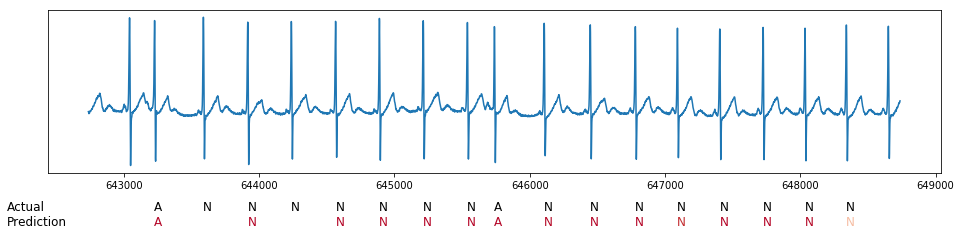

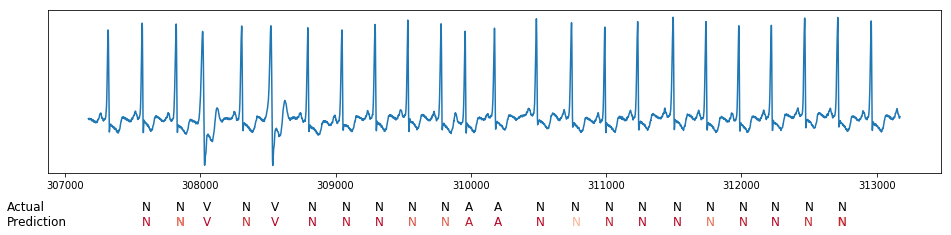

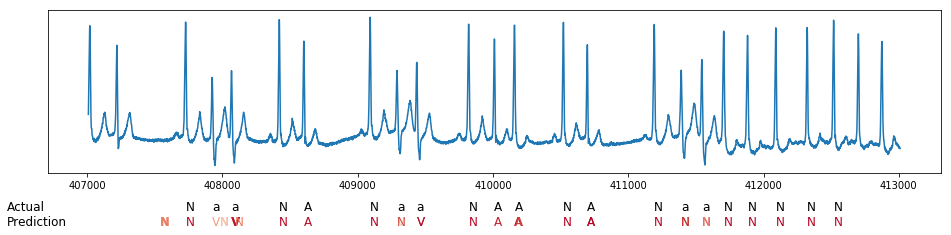

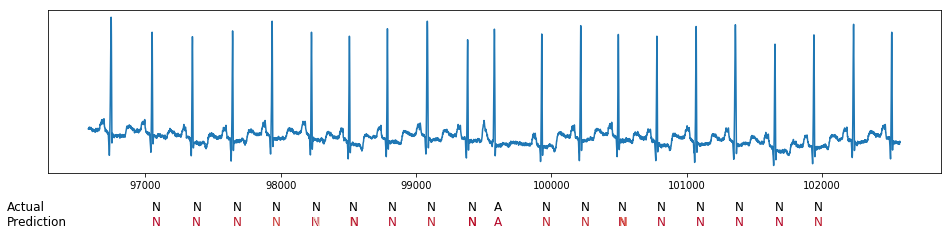

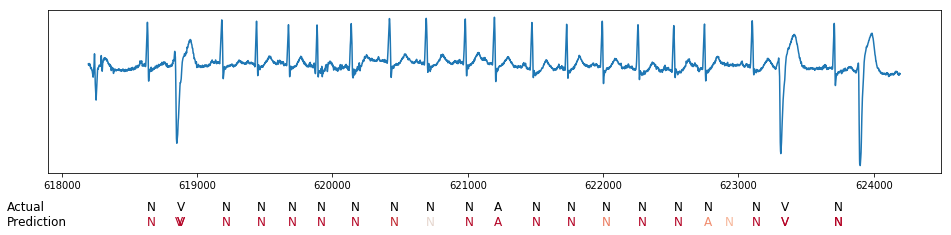

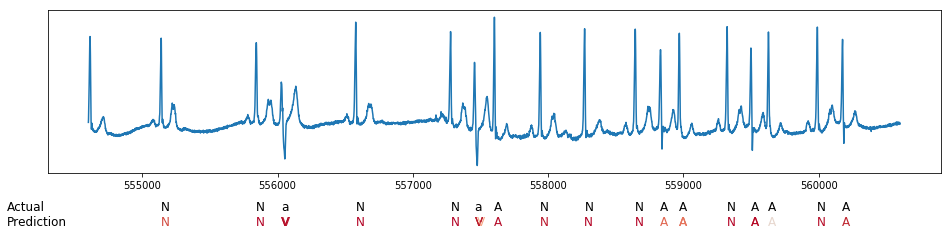

In [89]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['A'])

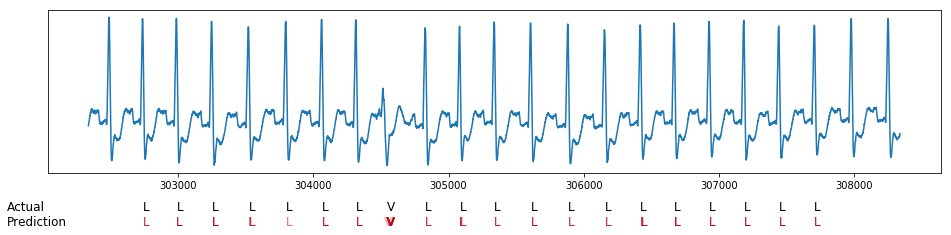

ValueError: cannot reshape array of size 2608 into shape (28,28,1)

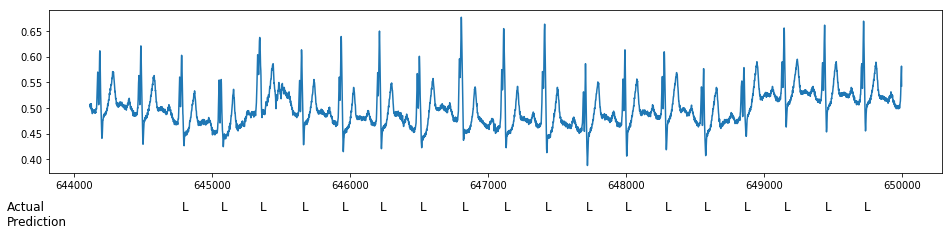

In [90]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['L'])

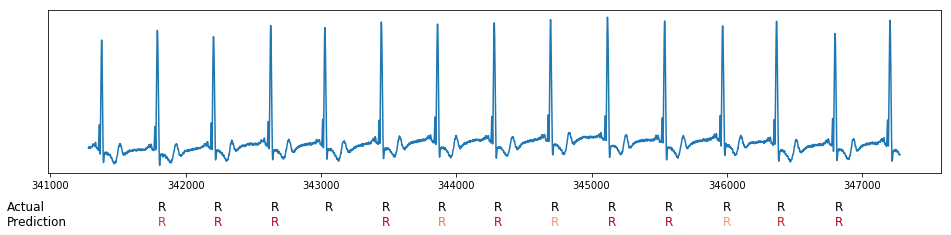

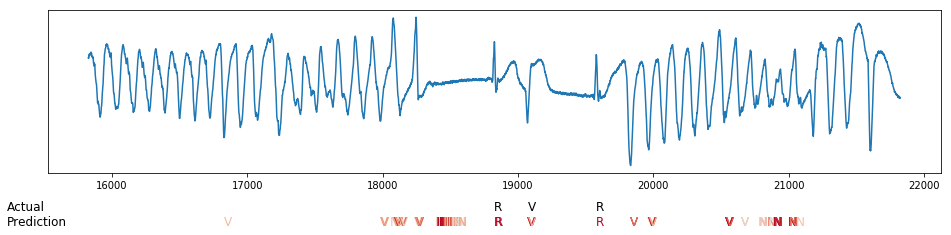

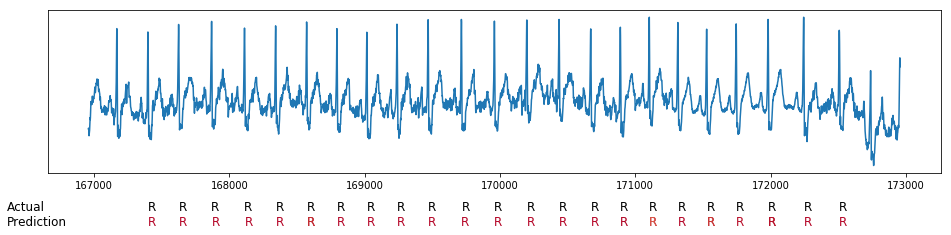

In [91]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['R'])

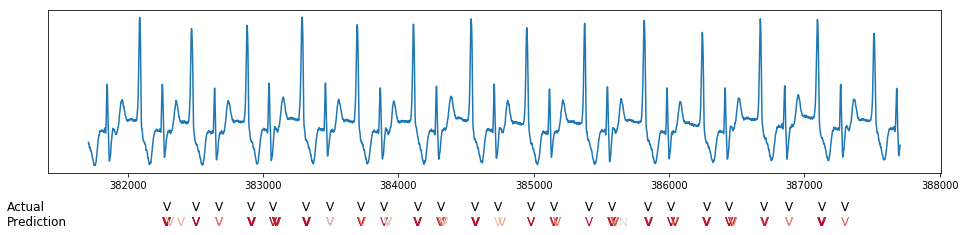

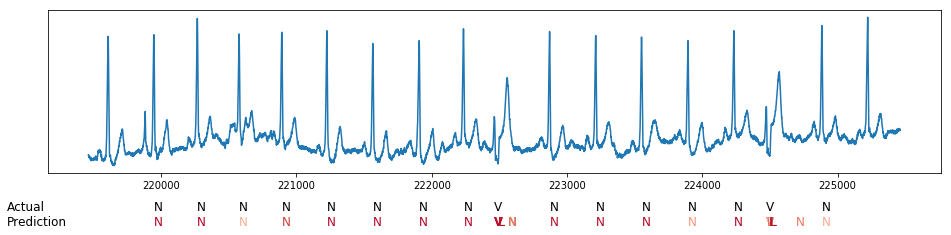

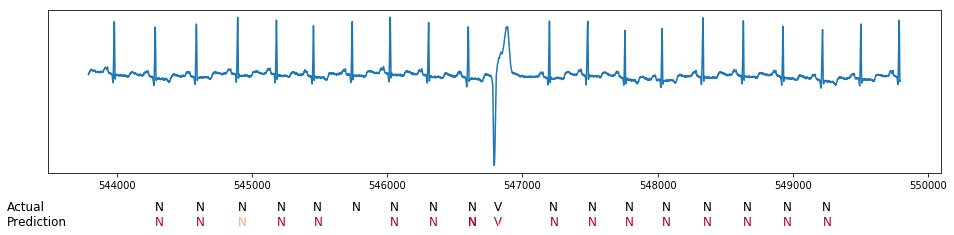

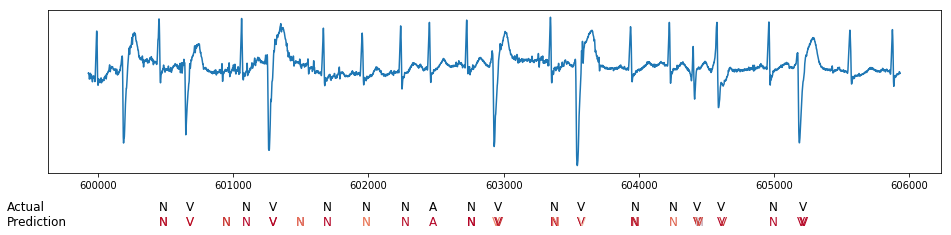

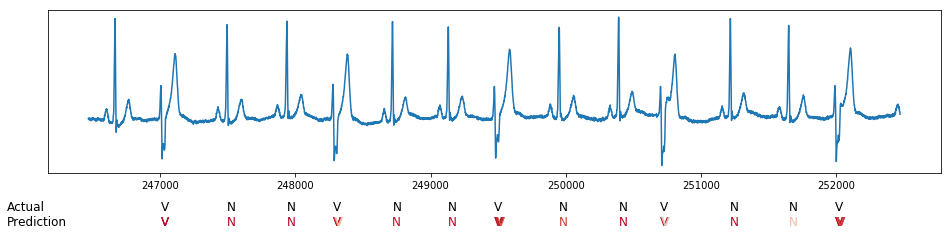

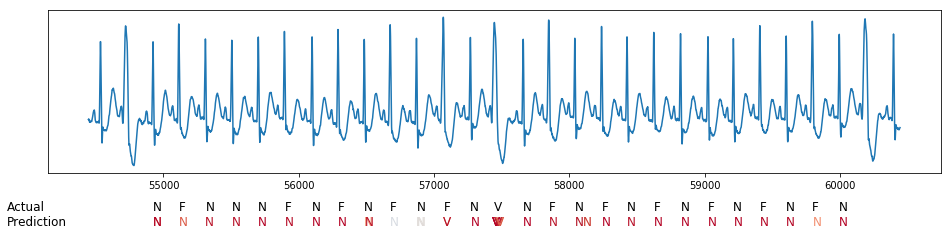

In [92]:
plot_validation_diagrams(tm, lb.classes_, validation, beat_types=['V'])